Desenvolvemos aqui um modelo para predição de fraude, utilizando idéias obtidas na análise dos dados.

# Inicialização

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import missingno as msno
import gc

from ast import literal_eval

style.use('bmh')

%matplotlib inline

In [2]:
# Lendo os conjuntos de dados
acq_train = pd.read_csv('../data/acquisition_train.csv')
acq_test = pd.read_csv('../data/acquisition_test.csv')
spend_train = pd.read_csv('../data/spend_train.csv')

# Limpeza dos dados

In [6]:
acq_train.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,...,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,4.500000e+04,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,...,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,...,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,4.030000e+02,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,...,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,5.094825e+04,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,...,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,1.017790e+05,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,...,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,1.513372e+05,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,...,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


## Manipulação de dados

Aplicamos aqui os mesmos procedimentos aplicados antes da análise exploratória:
* Criamos uma váriavel binária para indicar os valores conhecidos de fraude 
* Fazemos o *parsing* do horário de *application*, e guardamos apenas a hora do dia
* Fazemos o *parsing* de `lat_lon` em duas novas colunas
* Eliminamos a coluna de primeiro nome e telefones, pois não devem influenciar casos de fraude ou inadimplência (Telefones duplicados poderiam ser indicativo de fraude, mas não há duplicações)
* Alguns campos possuem valor infinito. Mudamos estes para ausentes (NaN)
* Criamos listas para ajudar a discernir os diferentes tipos de variáveis

In [3]:
acq_train['target_fraud_bin'] = acq_train['target_fraud'].apply(lambda x : False if pd.isna(x) else True)

In [4]:
parse_time_hour = lambda x: x.split(':')[0]

acq_train['application_hour_applied'] = pd.to_numeric(acq_train['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_train.drop('application_time_applied',inplace=True, axis=1)

acq_test['application_hour_applied'] = pd.to_numeric(acq_test['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_test.drop('application_time_applied',inplace=True, axis=1)

In [5]:
def lat_lon_parse (df):
    df['lat_lon'] = df['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
    df[['lat','lon']] = df['lat_lon'].apply(pd.Series)
    df.drop('lat_lon', inplace=True, axis=1)
    
lat_lon_parse(acq_train)
lat_lon_parse(acq_test)

In [6]:
acq_train.drop('external_data_provider_first_name',inplace=True,axis=1)
acq_test.drop('external_data_provider_first_name',inplace=True,axis=1)

In [7]:
category = ['ids',
 'score_1',
 'score_2',
 'profile_tags',
 'shipping_zip_code',
 'reason',
 'state',
 'zip',
 'job_name',
 'real_state',
 'user_agent',
 'email',
 'shipping_state',
 'marketing_channel'
]

binary = ['target_default',     
         'target_fraud_bin',
         'facebook_profile'
         ]

discrete = ['last_borrowed_in_months',
 'application_hour_applied',
  'ok_since',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'n_issues',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
  'external_data_provider_email_seen_before'
]

continuous = ['score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'application_time_in_funnel',
 'credit_limit',
 'income',
 'reported_income',    
 'external_data_provider_fraud_score',
 'lat',
 'lon']

for c in category:
    acq_train[c].astype('category')

In [8]:
# Ajustar valores de income
acq_train.replace(np.inf,np.nan, inplace=True)
acq_test.replace(np.inf,np.nan, inplace=True)

E aplicamos mais alguns passos:

* `channel` só possui um valor, então podemos eliminá-la pois não interfere no modelo
* Consertamos alguns *typos* em `email`

In [10]:
cols_todrop = ['channel']
acq_train.drop(cols_todrop,axis=1,inplace=True)
acq_test.drop(cols_todrop,axis=1,inplace=True)

In [11]:
# Email typos

def clean_replace(df, replace_dict):
    for key in replace_dict:
        for entry in replace_dict[key]:
            df[key].replace(entry[0],entry[1],inplace=True)
            

replace_dict = {}
replace_dict['email'] = [['gmaill.com','gmail.com'],['hotmaill.com','hotmail.com']]

clean_replace(acq_train,replace_dict)
clean_replace(acq_test,replace_dict)

## Valores ausentes

Preenchemos com zero alguns valores de quantidade, como empréstimos não pagos e valor do último empréstimo, assumindo que se não sabemos então não houve. Já valores de taxas, como scores, são preenchidos com a média da coluna, de forma a não interferir muito no modelo.

In [12]:
def fill_mean(df, col):
    df[col].fillna(df[col].mean(), inplace = True)
    
def fill_zero(df, col):
    df[col].fillna(0, inplace = True)
    
cols_fill_mean = ['score_3', 'risk_rate']
cols_fill_zero = ['n_defaulted_loans','last_amount_borrowed', 'last_borrowed_in_months']

for c in cols_fill_mean:
    fill_mean(acq_train,c)
    fill_mean(acq_test,c)
    
for c in cols_fill_zero:
    fill_zero(acq_train,c)
    fill_zero(acq_test,c)

Preenchemos os demais com -1 para sinalizar valor ausente.

In [13]:
acq_train.fillna(-1, inplace=True)
acq_test.fillna(-1, inplace=True)

## One-hot encoding

Aplicamos one-hot encoding em valores categóricos com até 10 valores únicos. Este limite é imposto para evitar muitas colunas no dataset.

In [14]:
def OHE_by_unique(train, one_hot, limit):
    
    one_hot_cat = []
    #ONE-HOT enconde features with more than 2 and less than 'limit' unique values
    df = train.copy()
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
                one_hot_cat.append(c+'_oh_' + str(val))
                
    return df, one_hot_cat

In [26]:
one_hot = {c: list(acq_train[c].unique()) for c in category if c not in ['ids']}

In [52]:
train_ohe, one_hot_cat = OHE_by_unique(acq_train, one_hot, 10)
test_ohe, _ = OHE_by_unique(acq_test, one_hot, 10)

# Modelagem

## Seleção de *features*

Definimos como target a variável binária de fraude, como dito anteriormente, e utilizamos um conjunto de variáveis como possibilidade para o modelo. Então treinamos um modelo simples de RandomForest e vemos quais são as principais features consideradas.

In [40]:
target = 'target_fraud_bin'
all_variables =  continuous + discrete + one_hot_cat + ['facebook_profile', target]

In [41]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [42]:
train = train_ohe[all_variables]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=5, max_features=0.2, n_jobs=-1, random_state=42)
rf.fit(train.drop([target],axis=1), train[target])
features = train.drop([target],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [43]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

O gráfico a seguir mostra as 10 variáveis mais importantes de acordo com o modelo:

[Text(0, 0.5, 'Nome da variável'),
 Text(0.5, 0, 'Importância'),
 Text(0.5, 1.0, 'Importância das variáveis')]

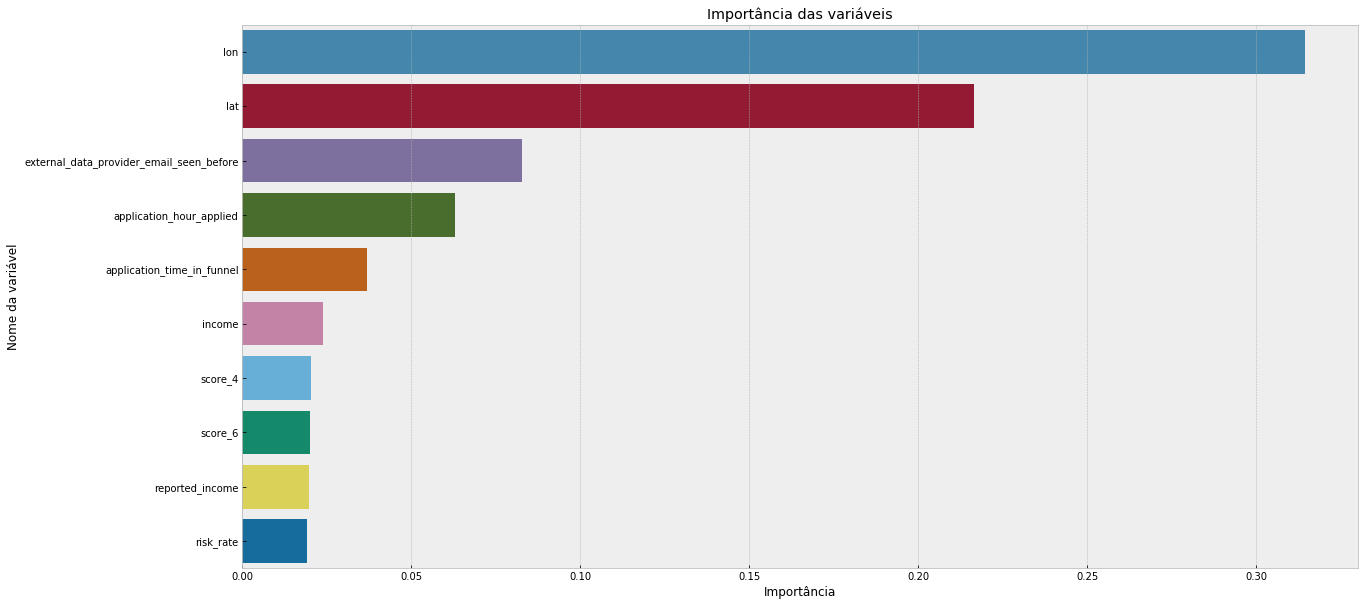

In [44]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:10],y="feature",x="importance",ax=ax)
ax.set(ylabel='Nome da variável', xlabel='Importância',title="Importância das variáveis")

Utilizaremos estas variáveis no nosso modelo final.

In [31]:
variables = feature_importance[:10].feature.tolist()

In [32]:
def cross_val_model(X,y, model, n_splits=5):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    X = np.array(X)
    y = np.array(y)


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

Escolhemos a métrica `StratifiedKFold` e `roc_auc` por se tratar de um conjunto enviesado, como visto na exploração dos dados. Em outras palavras, as classes possíveis para o alvo não estão balanceadas.

## Modelo

In [33]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 8
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30

rf_model = RandomForestClassifier(**rf_params)

In [34]:
X = train_ohe[variables]
y = train_ohe[target]

In [35]:
cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.86169
Fit RandomForestClassifier fold 2
    cross_score: 0.86194
Fit RandomForestClassifier fold 3
    cross_score: 0.88322
Fit RandomForestClassifier fold 4
    cross_score: 0.85846
Fit RandomForestClassifier fold 5
    cross_score: 0.86223


## Análise do resultado

Analisamos a seguir como fica a distribuição dos valores da predição no próprio conjunto de treino, para termos uma noção de como o modelo está.

In [48]:
train_pred = train_ohe.copy()
train_pred['pred'] = rf_model.predict_proba(train_ohe[variables])[:,1]

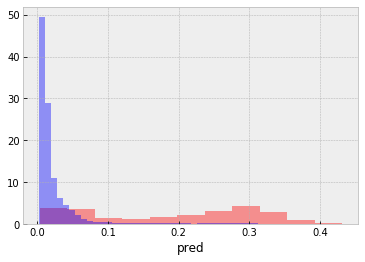

In [51]:
sns.distplot(train_pred[train_pred[target]==True].pred, norm_hist=True, kde=False, color='r')
sns.distplot(train_pred[train_pred[target]==False].pred, norm_hist=True, kde=False, color='b')

Podemos observar que os valores sem fraude se concentram perto de zero, como deveria ser; enquanto os casos de fraude se espalham ao longo do eixo, mas se concentram em torno de 0.3. Apesar de alguma interseção, há boa separação entre as duas classes.

## Saída

In [73]:
output = pd.DataFrame(columns=['ids','fraud'])
output['ids'] = test_ohe['ids'].values
output['fraud'] = rf_model.predict_proba(test_ohe[variables])[:,1]
output.to_csv('fraud.csv', index=False)